In [1]:
import numpy as np
import keras
import tensorflow as tf 
from keras.layers import Conv2D, Dense
from keras.layers import concatenate, add
from keras.layers import BatchNormalization, Activation, PReLU
from keras.layers import Input, Flatten, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.applications.vgg19 import VGG19
from shutil import rmtree
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
if tf.test.is_built_with_cuda():
    data_format = 'channels_last'
    keras.backend.set_image_data_format('channels_last')
else:
    data_format = 'channels_last'
    keras.backend.set_image_data_format('channels_last')

In [3]:
B = 16 # number of residual block

batch_size = 16
target_size = (96,96)
downscale_factor = 2

num_steps = 1e5
steps_per_epoch = 5000
epochs = int(num_steps//steps_per_epoch)

# axis used in Parametric ReLU !
shared_axis = [1,2] if data_format == 'channels_last' else [2,3]

# axis for Batch Normalization
axis = -1 if data_format == 'channels_last' else 1

In [4]:
# build a residual block
def res_block(inputs):
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(inputs)
    x = BatchNormalization(axis=axis)(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization(axis=axis)(x)
    return add([x, inputs])

# build an upscale block
# PixelShuffler is replaced by an UpSampling2D layer (nearest upsampling)

def up_block(x):
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) , padding='same', activation=None, use_bias=False)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    return x

In [5]:
data_format

'channels_last'

In [6]:
input_generator = Input(shape=(256, 256, 1) if data_format=='channels_last' else (128,128,3), 
                        name='input_generator')

x = Conv2D(filters=64, kernel_size=(9,9),
           strides=(1,1), padding='same',
           activation=None)(input_generator)

x_input_res_block = PReLU(alpha_initializer='zeros',
                          alpha_regularizer=None,
                          alpha_constraint=None,
                          shared_axes=shared_axis)(x)

x = x_input_res_block

# add B residual blocks 
for i in range(B):
    x = res_block(x)

x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
x = BatchNormalization(axis=axis)(x)

# skip connection
x = add([x, x_input_res_block])

# two upscale blocks
#x = up_block(x)
#x = up_block(x)

# final conv layer : activated with tanh -> pixels in [-1, 1]
output_generator = Conv2D(1, kernel_size=(9,9), 
                          strides=(1,1), activation='tanh',
                          use_bias=False, padding='same')(x)

generator1 = Model(inputs=input_generator, outputs=output_generator)

W0726 22:23:27.643609 47682019000320 deprecation.py:506] From /home/s28sengu/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
generator1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_generator (InputLayer)    (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 5248        input_generator[0][0]            
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 256, 256, 64) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36864       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

In [6]:
def preproces_vgg(x):
    # scale from [-1,1] to [0, 255]
    x += 1.
    x *= 127.5
    
    # RGB -> BGR
    if data_format == 'channels_last':
        x = x[..., ::-1]
    else:
        x = x[:,::-1,:,:]
    
    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    x = K.bias_add(x, K.cast(_IMAGENET_MEAN, K.dtype(x)))
    
    return x

In [7]:
def vgg_loss(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(weights='/home/s28sengu/scratch/dataset/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    
    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block2_conv2").output)
    
    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    features_pred = features_extractor(preproces_vgg(y_pred))
    features_true = features_extractor(preproces_vgg(y_true))
    
    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)


In [8]:
def loss_lap(y_true, y_pred):
  #y_true1 = y_true.eval(session=tf.compat.v1.Session())
  #y_pred1 = y_pred.eval(session=tf.compat.v1.Session())
    y_true = tf.image.sobel_edges(y_true)
    y_pred = tf.image.sobel_edges(y_pred)
    y_true1 = y_true[0,:,:,0,0]
    y_pred1 = y_pred[0,:,:,0,0]
    y_true2 = tf.reshape(y_true1, (1,256,256,1))
    y_pred2 = tf.reshape(y_pred1, (1,256,256,1))
    x1 = y_true2
    y1 = y_pred2
    ave_x1 = K.mean(x1)
    ave_y1 = K.mean(y1)
    var_x1 = K.var(x1)
    var_y1 = K.var(y1)
    covariance1 = K.mean(x1*y1) - ave_x1*ave_y1
    c1 = 0.01**2
    c2 = 0.03**2
    ssim1 = (2*ave_y1*ave_x1+c1)*(2*covariance1+c2)
    ssim1 = ssim1/((K.pow(ave_x1,2)+K.pow(ave_y1,2)+c1) * (var_x1+var_y1+c2))
    dssim1 = 1 - ssim1
    x = y_true
    y = y_pred
    ave_x = K.mean(x)
    ave_y = K.mean(y)
    var_x = K.var(x)
    var_y = K.var(y)
    covariance = K.mean(x*y) - ave_x*ave_y
    c1 = 0.01**2
    c2 = 0.03**2
    ssim = (2*ave_y*ave_x+c1)*(2*covariance+c2)
    ssim = ssim/((K.pow(ave_x,2)+K.pow(ave_y,2)+c1) * (var_x+var_y+c2))
    dssim = 1 - ssim
    return dssim 

In [9]:
opt = Adam(lr=1e-4, beta_1=0.9)
generator1.compile(loss='mean_squared_error', optimizer=opt)

In [18]:
import os
os.mkdir('/home/s28sengu/scratch/dataset/srres/motion_128/')

FileExistsError: [Errno 17] File exists: '/home/s28sengu/scratch/dataset/srres/motion_128/'

In [9]:
lr=np.load('/home/s28sengu/scratch/dataset/messidor_defocus_blu_128.npy')
hr=np.load('/home/s28sengu/scratch/dataset/messidorhi.npy')

In [10]:
'''
lr_train=lr[0:698,:,:,:]
hr_train=hr[0:698,:,:,:]
lr_test=lr[699:798,:,:,:]
hr_test=hr[699:798,:,:,:]
'''
lr_train=np.load('/home/s28sengu/scratch/octnoisy/noisy_oct_final_train.npy')
hr_train=np.load('/home/s28sengu/scratch/octnoisy/denoised_oct_final_train.npy')
lr_test=np.load('/home/s28sengu/scratch/octnoisy/noisy_oct_final_test.npy')
hr_test=np.load('/home/s28sengu/scratch/octnoisy/denoised_oct_final_test.npy')


In [11]:
lr_train=np.reshape(lr_train, (1400,256,256,1))
hr_train=np.reshape(hr_train, (1400,256,256,1))
lr_test=np.reshape(lr_test, (200,256,256,1))
hr_test=np.reshape(hr_test, (200,256,256,1))

In [12]:
checkpoint = ModelCheckpoint(filepath='/home/s28sengu/scratch/dataset/srres/defocus_128/weights.{epoch:02d}-{loss:.2f}.hdf5',
                             monitor='loss',
                             save_weights_only=True,
                             period=10,
                             verbose=2)
best_checkpoint = ModelCheckpoint(filepath='/home/s28sengu/scratch/dataset/srres/defocus_128/weights.{epoch:02d}-{loss:.2f}.hdf5',
                                  monitor='loss',
                                  save_weights_only=True,
                                  save_best_only=True, 
                                  period=1,
                                  verbose=2)
early_stop = EarlyStopping(monitor='loss',min_delta=0, patience=3, verbose=1, mode='min')
callbacks = [checkpoint, best_checkpoint,  early_stop]

In [13]:
generator1.fit(x=lr_train, y=hr_train, batch_size=1,
                                  epochs=100,
                                  callbacks=callbacks)

W0726 22:24:02.710968 47682019000320 module_wrapper.py:139] From /home/s28sengu/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/100
1400/1400 [==============================] - 145s 104ms/step - loss: 7403.1737

Epoch 00001: loss improved from inf to 7403.17372, saving model to /home/s28sengu/scratch/dataset/srres/defocus_128/weights.01-7403.17.hdf5
Epoch 2/100
1400/1400 [==============================] - 134s 96ms/step - loss: 7402.5809

Epoch 00002: loss improved from 7403.17372 to 7402.58086, saving model to /home/s28sengu/scratch/dataset/srres/defocus_128/weights.02-7402.58.hdf5
Epoch 3/100
1400/1400 [==============================] - 134s 96ms/step - loss: 7402.5809

Epoch 00003: loss did not improve from 7402.58086
Epoch 4/100
1400/1400 [==============================] - 135s 96ms/step - loss: 7402.5809

Epoch 00004: loss did not improve from 7402.58086
Epoch 5/100
1400/1400 [==============================] - 135s 96ms/step - loss: 7402.5809

Epoch 00005: loss did not improve from 7402.58086
Epoch 00005: early stopping


In [13]:
generator1.save('/home/s28sengu/scratch/dataset/srres/defocus_128/defocus_128.h5')

/home/s28sengu/.local/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [26]:
from keras.models import load_model
a1=load_model('/home/s28sengu/scratch/dataset/srres/defocus_128/defocus_128.h5')

/home/s28sengu/.local/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [27]:
a1.compile

<bound method Model.compile of <keras.engine.training.Model object at 0x2ad76ba25e80>>

In [33]:
test=lr_test[40]
test1=np.reshape(test,(1,256,256,1))
a=generator1.predict(test1)

In [37]:
a[0].shape

(256, 256, 1)

TypeError: Invalid dimensions for image data

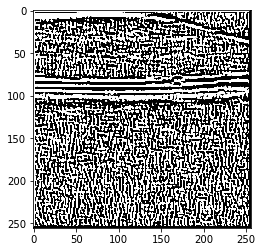

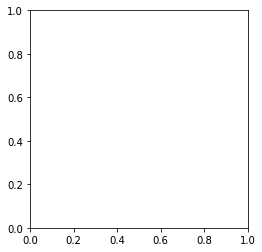

In [39]:
plt.imshow(a[0][:,:,0],cmap='gray')
plt.figure()
plt.imshow(hr_test[40])

In [14]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    PIXEL_MAX = 255.0
    return 10 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [28]:
psnr1=[]
for t1 in range(len(lr_test)):
    test=lr_test[t1]
    test1=np.reshape(test,(1,128,128,3))
    a=a1.predict(test1)
    val=psnr(hr_test[t1],a[0])
    psnr1.append(val)

In [29]:
sum(psnr1)/len(psnr1)

39.35686711205361

W0205 18:43:53.566887 47077596471296 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


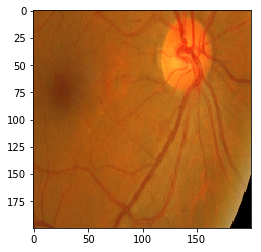

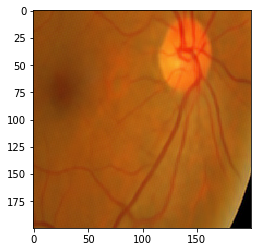

In [22]:
plt.imshow(hr_test[t1][200:400,200:400])
plt.figure()
plt.imshow(a[0][200:400,200:400])

In [56]:
s_test=[]
s_cv=[]
for t1 in range(len(lr_test)):
    x1=lr_test[t1]
    lr2= x1.reshape((1,128,128,3))
    #x1.reshape((1,256,256,3))
    x_hr=a1.predict(lr2)
    s_test.append(loss_G1(x_hr[0],hr_test[t1]))
    #print(ssim(ytest[t1],x_hr[0]))
    #p_cv.append(psnr(ytest[t1],cv2.resize(xtest[t1],(512,512))))

In [32]:
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from PIL import Image

In [57]:
s_test

[0.9837705334293948,
 0.9562372198842966,
 0.9865777226615131,
 0.9758271918471296,
 0.9834960496792172,
 0.9897838594586355,
 0.9820515565508242,
 0.9732362533475605,
 0.9880862004313726,
 0.9841870590912322,
 0.9795940256866933,
 0.9779163841607619,
 0.9911382795383578,
 0.9781005820182973,
 0.973338368369306,
 0.9763872241682982,
 0.9819277785751307,
 0.970652951126579,
 0.9897091859801006,
 0.9876410967502145,
 0.9889359877434858,
 0.9808929366185707,
 0.9883948811204137,
 0.9774639827548686,
 0.9890194063460916,
 0.9756737568511074,
 0.9786278674334621,
 0.983793142948585,
 0.9824940020116926,
 0.9804409304743792,
 0.9897763814479671,
 0.9757756298212391,
 0.9877071285584293,
 0.9807489752858354,
 0.9857988031141044,
 0.9825757271793355,
 0.9813704976961712,
 0.9859677022664579,
 0.9794228730146848,
 0.9776166125610111,
 0.9817367789576981,
 0.9786147049497232,
 0.9859410124967525,
 0.9722326506779766,
 0.9908895306578315,
 0.9794965838750896,
 0.9810144951940278,
 0.9891274251822

W0205 20:43:23.039628 47077596471296 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


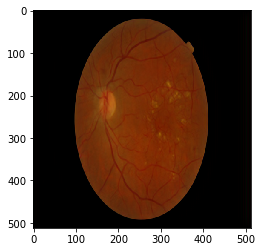

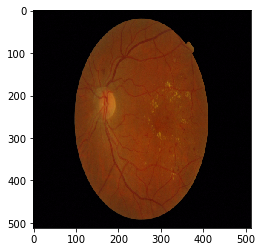

In [37]:
x1=lr_test[14]
lr2= x1.reshape((1,128,128,3))
x_hr=a1.predict(lr2)
plt.imshow(x_hr[0])
plt.figure()
plt.imshow(hr_test[14])

In [58]:
sum(s_test)/len(s_test)

0.9821544200447543

In [ ]:
def loss_G1(y_true, y_pred):
        L1_distance = np.mean(K.abs((y_true-y_pred)**2))
        x = y_true
        y = y_pred
        ave_x = np.mean(x)
        ave_y = np.mean(y)
        var_x = np.var(x)
        var_y = np.var(y)
        covariance = np.mean(x*y) - ave_x*ave_y
        c1 = 0.01**4
        c2 = 0.03**4
        ssim = (2*ave_y*ave_x+c1)*(2*covariance+c2)
        ssim = ssim/((pow(ave_x,2)+pow(ave_y,2)+c1) * (var_x+var_y+c2))
        #dssim = 1 - ssim
        return ssim